# Quiz 4 - Geração de Mosaicos

### Matheus Pimenta

O objetivo deste Quiz é criar um mosaico utilizando um conjunto de fotos adquiridas rotacionado
uma câmera em torno de um de seus eixos.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

## Parte 1: 

Nesse primeiro passo iremos fazer detecção de keypoints via SIFT, a extração dos descritores (SIFT e
BRIEF) e o casamento dos pares de keypoints correspondentes. Usaremos esse conjunto de pares para a estimação do matriz de homografia.

Foi necessário diminuir a imagem. Acima de 20% o notebook travava (mas voltava depois de um tempo, coisa que não aconteceu acima dos 50%).

In [2]:
def reduce_img(img, percent):
    width = int(img.shape[1] * percent / 100)
    height = int(img.shape[0] * percent / 100)
    dim = (width, height)
    img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    return img

Primeiramente, vamos carregar as imagens e ter cópias delas em escala de cinza:

In [3]:
img1 = cv.imread('set1/img1-set1.jpg')
img2 = cv.imread('set1/img2-set1.jpg')
img3 = cv.imread('set1/img3-set1.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

img1 = reduce_img(img1, 15)
img2 = reduce_img(img2, 15)
img3 = reduce_img(img3, 15)

In [4]:
gray1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)
gray3 = cv.cvtColor(img3,cv.COLOR_BGR2GRAY)


Definindo funções para obtenção dos keypoints e dos descritores, e já calculando 

In [5]:
def get_keypoints_SIFT(sift, img):
    return sift.detect(img,None)

def get_SIFT_descriptors(img, sift, keypoints):
    k, d = sift.compute(img, keypoints)
    return k, d

def get_BRIEF_descriptors(img, brief, keypoints):
    k, d = brief.compute(img, keypoints)
    return k, d
    
sift = cv.SIFT_create()
brief = cv.xfeatures2d.BriefDescriptorExtractor_create()

sift_kp1 = get_keypoints_SIFT(sift, gray1)
sift_kp2 = get_keypoints_SIFT(sift, gray2)
sift_kp3 = get_keypoints_SIFT(sift, gray3)

sift_kp1, sift_des1 = get_SIFT_descriptors(gray1, sift, sift_kp1)
sift_kp2, sift_des2 = get_SIFT_descriptors(gray2, sift, sift_kp2)
sift_kp3, sift_des3 = get_SIFT_descriptors(gray3, sift, sift_kp3)


brief_kp1, brief_des1 = get_BRIEF_descriptors(gray1, brief, sift_kp1)
brief_kp2, brief_des2 = get_BRIEF_descriptors(gray2, brief, sift_kp2)
brief_kp3, brief_des3 = get_BRIEF_descriptors(gray3, brief, sift_kp3)

Vamos visualizar os keypoints, a partir da função cv2.drawKeypoints()

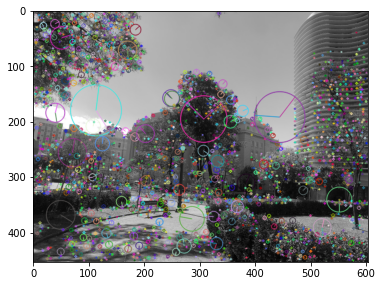

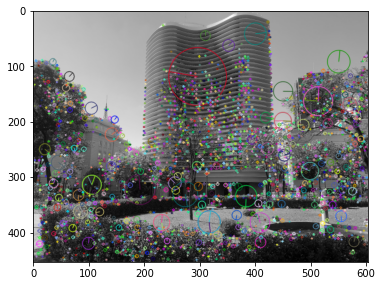

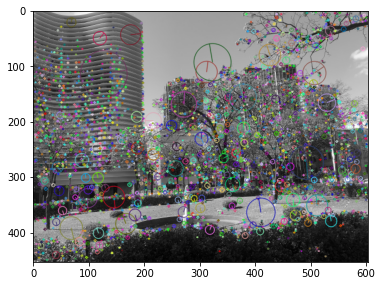

In [6]:
cp_img1 = gray1.copy()
cp_img2 = gray2.copy()
cp_img3 = gray3.copy()

cp_img1 = cv.drawKeypoints(cp_img1,sift_kp1,cp_img1,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cp_img2 = cv.drawKeypoints(cp_img2,sift_kp2,cp_img2,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cp_img3 = cv.drawKeypoints(cp_img3,sift_kp3,cp_img3,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# mostrar BRIEF

plt.figure(figsize=(6,6))
plt.imshow(cp_img1)
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(cp_img2)
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(cp_img3)
plt.show()

Já podemos perceber que mesmo com escala reduzida, são muito os keypoints obtidos. Também, alguns keypoints obtidos em uma imagem não foram obtidos na outra (pelo menos não do mesmo jeito), como por exemplo o grande verde claro do prédio maior na imagem 3, que não está na imagem dois.

Com os descritores e keypoints em mãos, podemos calcular o matching (também definindo em funções para usar mais tarde).

In [7]:
def get_matches(bf,desc1, desc2):
    return bf.match(desc1, desc2)

def format_src_matches(keyp, desc):
    return np.float32([ keyp[m.queryIdx].pt for m in desc ]).reshape(-1,1,2)

def format_dst_matches(keyp, desc):
    return np.float32([ keyp[m.trainIdx].pt for m in desc ]).reshape(-1,1,2)

bf_sift = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
bf_brief = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

matches_sift_1to2 = get_matches(bf_sift, sift_des1,sift_des2)
matches_sift_3to2 = get_matches(bf_sift, sift_des3,sift_des2)

matches_brief_1to2 = get_matches(bf_brief,brief_des1, brief_des2)
matches_brief_3to2 = get_matches(bf_brief, brief_des3, brief_des2)

# teste = cv.drawMatches(gray1,brief_kp1,gray2,brief_kp2,matches,None,flags=2)

# plt.figure(figsize=(10,10))
# plt.imshow(teste)
# plt.show()

Se faz necessário converter o resultado, já que o formato resultande do matching é diferente. Vamos converter para np.float32

In [8]:
src_pts_sift_1to2 = format_src_matches(sift_kp1, matches_sift_1to2)
dst_pts_sift_1to2 = format_dst_matches(sift_kp2, matches_sift_1to2)

# src_pts_sift_1to3 = np.float32([ sift_kp1[m.queryIdx].pt for m in matches_sift_1to3 ]).reshape(-1,1,2)
# dst_pts_sift_1to3 = np.float32([ sift_kp2[m.trainIdx].pt for m in matches_sift_1to3 ]).reshape(-1,1,2)

src_pts_sift_3to2 = format_src_matches(sift_kp3, matches_sift_3to2)
dst_pts_sift_3to2 = format_dst_matches(sift_kp2, matches_sift_3to2)

src_pts_brief_1to2 = format_src_matches(brief_kp1, matches_brief_1to2)
dst_pts_brief_1to2 = format_dst_matches(brief_kp2, matches_brief_1to2)

# src_pts_brief_1to3 = np.float32([ sift_kp1[m.queryIdx].pt for m in matches_brief_1to3 ]).reshape(-1,1,2)
# dst_pts_brief_1to3 = np.float32([ sift_kp2[m.trainIdx].pt for m in matches_brief_1to3 ]).reshape(-1,1,2)

src_pts_brief_3to2 = format_src_matches(brief_kp3, matches_brief_3to2)
dst_pts_brief_3to2 = format_dst_matches(brief_kp2, matches_brief_3to2)

# print(src_pts)
# print(dst_pts)



Por fim, vamos definir a função que calcula a Homografia, e também adiantar a função para realizar o warp.

In [9]:
def get_Homography(src_points, dst_points):
    H, mask = cv.findHomography(src_points, dst_points, cv.RANSAC,5.0)
    return H, mask

In [10]:


def warp_images(img1, img2, H, f=True):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0,rows1], [cols1, rows1], [cols1, 0]]).reshape(-1,1,2)
    temp_points = np.float32([[0,0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1,1,2)

    list_of_points_2 = cv.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1,0,translation_dist[0]], [0,1,translation_dist[1]],[0,0,1]])

    output_img = cv.warpPerspective(img1, H_translation.dot(H), (x_max-x_min, y_max-y_min))

    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img2
  

    return output_img

## Parte 2: Transformar a imagem com as matrizes estimadas

Temos tudo pronto pra calcular as imagens. Primeiro vamos juntar a imagem 1 com a 2 (2 de base), e depois a 3 com a 2 (novamente com a 2 de base). Vamos fazer tanto para o SIFT quanto o BRIEF.

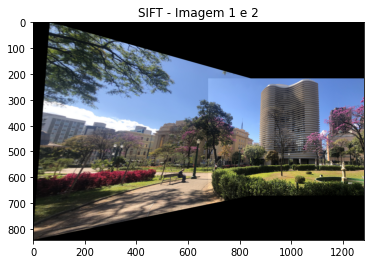

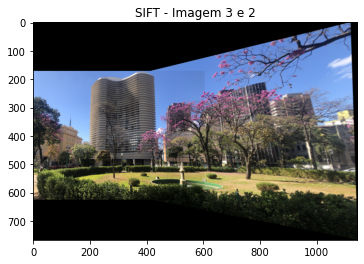

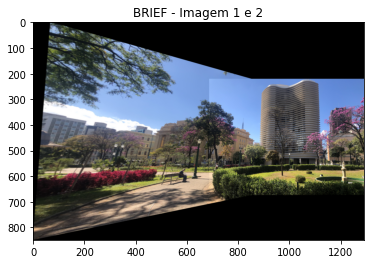

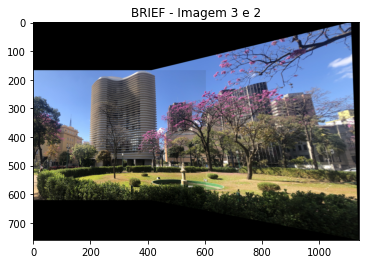

In [11]:
H_sift_1to2, mask_sift_1to2 = get_Homography(src_pts_sift_1to2, dst_pts_sift_1to2)
img_1and2 = warp_images(img1, img2, H_sift_1to2, f=True)
plt.title("SIFT - Imagem 1 e 2")
plt.imshow(img_1and2)
plt.show()

H_sift_3to2, mask_sift_3to2 = get_Homography(src_pts_sift_3to2, dst_pts_sift_3to2)
img_3and2 = warp_images(img3, img2, H_sift_3to2, f=True)
plt.title("SIFT - Imagem 3 e 2")
plt.imshow(img_3and2)
plt.show()

H_brief_1to2, mask_brief_1to2 = get_Homography(src_pts_brief_1to2, dst_pts_brief_1to2)
img_1and2_b = warp_images(img1, img2, H_brief_1to2, f=True)
plt.title("BRIEF - Imagem 1 e 2")
plt.imshow(img_1and2_b)
plt.show()

H_brief_3to2, mask_brief_3to2 = get_Homography(src_pts_brief_3to2, dst_pts_brief_3to2)
img_3and2_b = warp_images(img3, img2, H_brief_3to2, f=True)
plt.title("BRIEF - Imagem 3 e 2")
plt.imshow(img_3and2_b)
plt.show()


Analisando os resultados bem de perto, da pra perceber que o SIFT teve um desempenho melhor. Isso se dá porque os descritores do SIFT carregam mais informação, já que temos uma matriz de double VS uma binária. Porém, devido até a baixa resolução, o resultado do BRIEF é bem satisfatório. 

Vamos definir uma função que reune todos esses passos, e juntar as 3 imagens. Perceba que nesse caso temos que juntar a imagem 1-2 com a 3-2, senão teremos muitos problemas com shape. 

Vamos também carregar todos os sets de imagem.

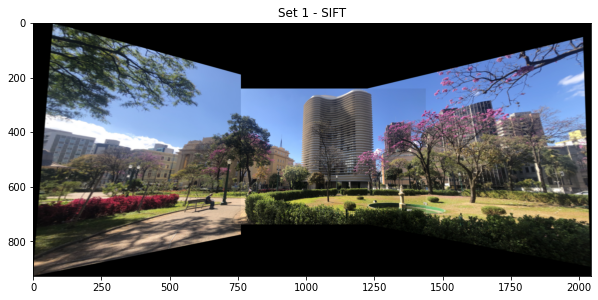

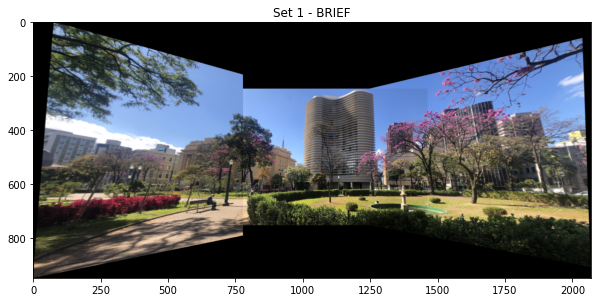

In [12]:
def generate_mosaic(img1, img2, mode):
    sift = cv.SIFT_create()    
    
    g1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    g2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

    keyp1 = get_keypoints_SIFT(sift, g1)
    keyp2 = get_keypoints_SIFT(sift, g2)

    if(mode == 'brief'):
        brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
        k1, d1 = get_BRIEF_descriptors(g1, brief, keyp1)
        k2, d2 = get_BRIEF_descriptors(g2, brief, keyp2)
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        
    elif(mode == 'sift'):
        k1, d1 = get_SIFT_descriptors(g1, sift, keyp1)
        k2, d2 = get_SIFT_descriptors(g2, sift, keyp2)

        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

    matches =  get_matches(bf, d1, d2)
    src = format_src_matches(k1, matches)
    dst = format_dst_matches(k2, matches)

    H, mask = get_Homography(src, dst)
    return warp_images(img1, img2, H, f=False)

img_3and2 = cv.resize(img_3and2,(img_1and2.shape[1],img_1and2.shape[0]))
img_3and2_b = cv.resize(img_3and2_b,(img_1and2_b.shape[1],img_1and2_b.shape[0]))

final1_sift = generate_mosaic(img_1and2, img_3and2, 'sift')
plt.figure(figsize=(10,10))
plt.imshow(final1_sift)
plt.title("Set 1 - SIFT")
plt.show()

final1_brief = generate_mosaic(img_1and2_b, img_3and2_b, 'brief')
plt.figure(figsize=(10,10))
plt.title("Set 1 - BRIEF")
plt.imshow(final1_brief)
plt.show()

Podemos ver que novamente o SIFT se sai melhor. Especialmente na árvoque que está na divisa da imagem 1 com a 2, o resultado do BRIEF parece mais que uma imagem foi sobreposta em cima da outra. Porém, não estão tão distoantes.

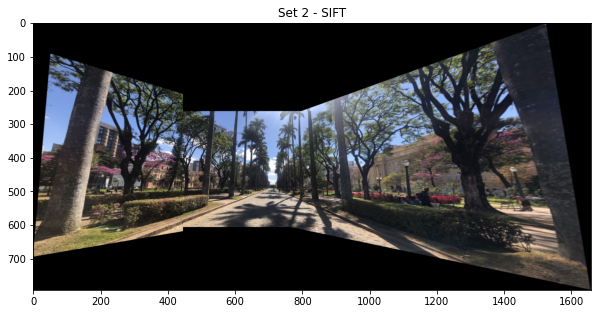

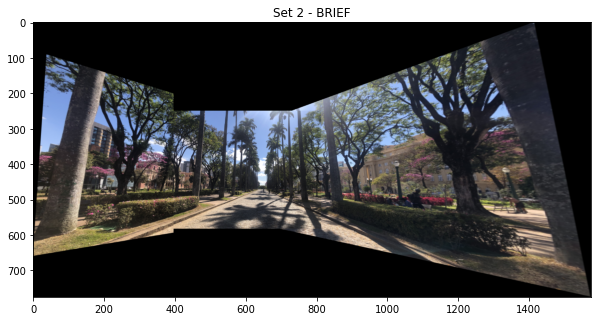

In [16]:
img1 = cv.imread('set2/img1-set2.jpg')
img2 = cv.imread('set2/img2-set2.jpg')
img3 = cv.imread('set2/img3-set2.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

img1 = reduce_img(img1, 15)
img2 = reduce_img(img2, 15)
img3 = reduce_img(img3, 15)

set2_1to2_sift = generate_mosaic(img1, img2, 'sift')
set2_3to2_sift = generate_mosaic(img3, img2, 'sift')
set2_3to2_sift = cv.resize(set2_3to2_sift,(set2_1to2_sift.shape[1],set2_1to2_sift.shape[0]))
final2_sift = generate_mosaic(set2_1to2_sift, set2_3to2_sift, 'sift')

set2_1to2_brief = generate_mosaic(img1, img2, 'brief')
set2_3to2_brief = generate_mosaic(img3, img2, 'brief')
set2_3to2_brief = cv.resize(set2_3to2_brief,(set2_1to2_brief.shape[1],set2_1to2_brief.shape[0]))
final2_brief = generate_mosaic(set2_1to2_brief, set2_3to2_brief, 'brief')


plt.figure(figsize=(10,10))
plt.title("Set 2 - SIFT")
plt.imshow(final2_sift)
plt.show()

plt.figure(figsize=(10,10))
plt.title("Set 2 - BRIEF")
plt.imshow(final2_brief)
plt.show()


 A iluminação do BRIEF aqui parece diferente, um pouco mais clara. Mas as imagens estão bem parecidas, da pra perceber que até a "quebra" da sombra entre a imagem 2 e 3 são parecidas.

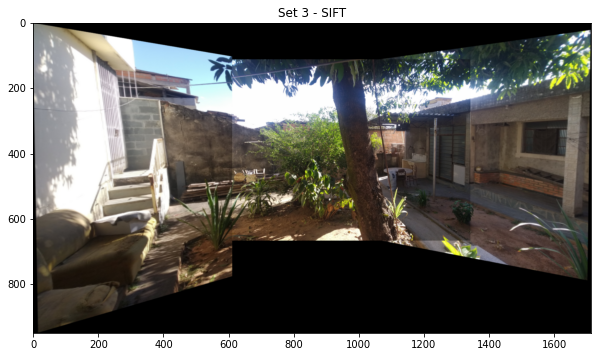

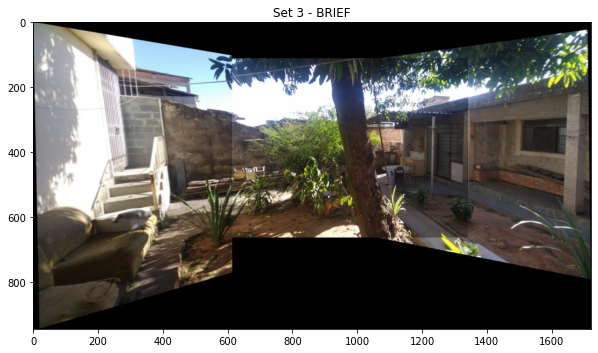

In [18]:
img1 = cv.imread('set3/img1-set3.jpg')
img2 = cv.imread('set3/img2-set3.jpg')
img3 = cv.imread('set3/img3-set3.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

img1 = reduce_img(img1, 15)
img2 = reduce_img(img2, 15)
img3 = reduce_img(img3, 15)

set3_1to2_sift = generate_mosaic(img1, img2, 'sift')
set3_3to2_sift = generate_mosaic(img3, img2, 'sift')
set3_3to2_sift = cv.resize(set3_3to2_sift,(set3_1to2_sift.shape[1],set3_1to2_sift.shape[0]))
final3_sift = generate_mosaic(set3_1to2_sift, set3_3to2_sift, 'sift')

set3_1to2_brief = generate_mosaic(img1, img2, 'brief')
set3_3to2_brief = generate_mosaic(img3, img2, 'brief')
set3_3to2_brief = cv.resize(set3_3to2_brief,(set3_1to2_brief.shape[1],set3_1to2_brief.shape[0]))
final3_brief = generate_mosaic(set3_1to2_brief, set3_3to2_brief, 'brief')


plt.figure(figsize=(10,10))
plt.title("Set 3 - SIFT")
plt.imshow(final3_sift)
plt.show()

plt.figure(figsize=(10,10))
plt.title("Set 3 - BRIEF")
plt.imshow(final3_brief)
plt.show()

Esse ficou bem interessante. De cara da pra perceber em como a câmera pegou uma intensividade diferente de luz, e o como o blending se faz necessário. Comparando as montagens, a do BRIEF está um pouco mais tortinha, o que da pra perceber nas plantinhas daqui de casa. Mas novamente, o do BRIEF testá bem satisfatório.

Pela necessidade de ter que rodar com pouca qualidade de imagem, os resultados serão mais parecidos mesmo, já que querendo ou não a menos coisa pra descrever. Mas não é como se fossem iguais: abaixo temos a comparação do tamanho dos matches encontrados, no sift e no brief, para a primeira e segunda imagem-set1.

In [20]:
print(len(matches_sift_1to2))
print(len(matches_brief_1to2))

1029
571


Portanto, percebemos que o SIFT é mais robusto, mas mostra que o BRIEF tem sim suas vantagens e aplicações.

## Parte 3 - Blending

Para o blending a mudança seria no warp_images, onde criariamos máscaras representando cada uma das estratégias e aplicar a mesma matriz de Homograma que já tinhamos calculado. Para o Straight averaging, a máscara inicial seria uma matriz binária, onde os 1's representam pixels onde tem a imagem. Já para o Feathering, em vez de 1's teriamos a relação com a distância da borda.